In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F

import sys
import os
sys.path.append(os.path.abspath(".."))
from models import *
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.cuda.set_device(0)
device = 'cuda'
dataset_path = '/narcissus/dataset/'

In [2]:
import os
import torchvision
import torchvision.transforms as transforms

dataset_path = os.path.expanduser("~/datasets/")
cifar10_path = os.path.join(dataset_path, "cifar-10-batches-py")

if not os.path.exists(cifar10_path):
    print("Downloading CIFAR-10...")
    torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True)
else:
    print("CIFAR-10 already downloaded.")


CIFAR-10 already downloaded.


In [3]:
import os
import urllib.request
import zipfile

tiny_imagenet_dir = os.path.join(dataset_path, "tiny-imagenet-200")

if not os.path.exists(tiny_imagenet_dir):
    print("Downloading Tiny ImageNet...")
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(dataset_path, "tiny-imagenet-200.zip")
    
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting Tiny ImageNet...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(zip_path)
    print("Done.")
else:
    print("Tiny ImageNet already downloaded.")


Tiny ImageNet already downloaded.


In [4]:
'''
The path for target dataset and public out-of-distribution (POOD) dataset. The setting used 
here is CIFAR-10 as the target dataset and Tiny-ImageNet as the POOD dataset. Their directory
structure is as follows:

dataset_path--cifar-10-batches-py
            |
            |-tiny-imagenet-200
'''
# dataset_path = '/home/minzhou/data/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18_201().cuda()
generating_model = ResNet18_201().cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

# Prepare dataset

In [5]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [6]:
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)

In [7]:
#Outter train dataset
train_label = [get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = [get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [8]:
#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(ori_train,train_target_list)

In [9]:
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)

In [10]:
surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

#  Training surrogate modle

In [11]:
# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
# outer_opt = torch.optim.RAdam(params=base_model.parameters(), lr=generating_lr_outer)
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

In [ ]:
save_path = 'surrogate.pth'

if os.path.exists(save_path):
    print(f"Loading pre-trained surrogate model from {save_path}")
    surrogate_model.load_state_dict(torch.load(save_path))
else:
    print('Training the surrogate model')
    for epoch in range(0, surrogate_epochs):
        surrogate_model.train()
        loss_list = []
        for images, labels in surrogate_loader:
            images, labels = images.cuda(), labels.cuda()
            surrogate_opt.zero_grad()
            outputs = surrogate_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            loss_list.append(float(loss.data))
            surrogate_opt.step()
        surrogate_scheduler.step()
        ave_loss = np.average(np.array(loss_list))
        print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
    
    torch.save(surrogate_model.state_dict(), save_path)


Training the surrogate model


Epoch:0, Loss: 4.621
Epoch:1, Loss: 3.893
Epoch:2, Loss: 3.407
Epoch:3, Loss: 3.074
Epoch:4, Loss: 2.832
Epoch:5, Loss: 2.634
Epoch:6, Loss: 2.481
Epoch:7, Loss: 2.368
Epoch:8, Loss: 2.273
Epoch:9, Loss: 2.186
Epoch:10, Loss: 2.128
Epoch:11, Loss: 2.066
Epoch:12, Loss: 2.005
Epoch:13, Loss: 1.959
Epoch:14, Loss: 1.914
Epoch:15, Loss: 1.875
Epoch:16, Loss: 1.837
Epoch:17, Loss: 1.801
Epoch:18, Loss: 1.774
Epoch:19, Loss: 1.739
Epoch:20, Loss: 1.718
Epoch:21, Loss: 1.687
Epoch:22, Loss: 1.667
Epoch:23, Loss: 1.640
Epoch:24, Loss: 1.622
Epoch:25, Loss: 1.610
Epoch:26, Loss: 1.584
Epoch:27, Loss: 1.556
Epoch:28, Loss: 1.543
Epoch:29, Loss: 1.521
Epoch:30, Loss: 1.503
Epoch:31, Loss: 1.489
Epoch:32, Loss: 1.480
Epoch:33, Loss: 1.459
Epoch:34, Loss: 1.443
Epoch:35, Loss: 1.435
Epoch:36, Loss: 1.427
Epoch:37, Loss: 1.406
Epoch:38, Loss: 1.390
Epoch:39, Loss: 1.381
Epoch:40, Loss: 1.365
Epoch:41, Loss: 1.347
Epoch:42, Loss: 1.341
Epoch:43, Loss: 1.336
Epoch:44, Loss: 1.319
Epoch:45, Loss: 1.30

# Poison warm up

In [ ]:
#cell 13
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)

In [ ]:
#cell 14
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))

torch.save(poi_warm_up_model.state_dict(), 'poi_warm_up_model.pth')

Epoch:0, Loss: 5.419091e-01
Epoch:1, Loss: 4.081329e-05
Epoch:2, Loss: 3.607796e-06
Epoch:3, Loss: 1.371848e-06
Epoch:4, Loss: 9.491324e-07


# Trigger generating

In [ ]:
#cell 15
from tqdm.notebook import tqdm

#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)
        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())

In [ ]:
#cell 16
#Save the trigger
import time
save_name = 'best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)

# Testing  attack effect

In [ ]:
# cell 17
# Using this block if you only want to test the attack result.
import imageio
import cv2 as cv
save_name = 'best_noise.npy'
best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load(save_name)
best_noise = torch.from_numpy(noise_npy).cuda()

In [ ]:
#cell 18
#Poisoning amount use for the target class
poison_amount = 25

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65

In [ ]:
# cell 19
import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
model = noise_testing_model

optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)

In [ ]:
# cell 20
transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])

In [ ]:
import torch.nn.functional as F

model = poi_warm_up_model
model.eval()

confidences = []

with torch.no_grad():
    for idx in train_target_list: 
        image, label = poi_ori_train[idx]
        image = image.unsqueeze(0).cuda()
        output = model(image)
        prob = F.softmax(output, dim=1)[0][label].item()
        confidences.append((idx, prob))

# Sort by confidence ascending (low confidence first)
confidences.sort(key=lambda x: x[1])

poison_amount_reduced = 20  #10
selected_poison_idx = [idx for idx, _ in confidences[:poison_amount_reduced]]

In [ ]:
#cell 21
#Poison traing
# random_poison_idx = random.sample(train_target_list, poison_amount)
poison_train_target = poison_image(poi_ori_train,selected_poison_idx,best_noise.cpu(),transform_after_train)

print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(selected_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

Traing dataset size is: 50000  Poison numbers is: 20


In [ ]:
#cell 22
#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [ ]:
#cell 23
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(ori_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [ ]:
#cell 24
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(ori_test,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [ ]:
#cell 25
from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []

In [ ]:
#cell 26
for epoch in tqdm.tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm.tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
    scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:41<00:00,  8.05it/s]

Train_loss: tensor(23.0941, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1392e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5305, device='cuda:0')


  0%|          | 1/200 [00:46<2:34:41, 46.64s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1742e-06, device='cuda:0')


Acc 10.01 Loss: 20.42: 100%|██████████| 334/334 [00:41<00:00,  7.98it/s]

Train_loss: tensor(21.0153, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3444e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.9690, device='cuda:0')


  1%|          | 2/200 [01:33<2:34:43, 46.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.0095e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:41<00:00,  8.01it/s]

Train_loss: tensor(23.5411, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2729e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1344, device='cuda:0')


  2%|▏         | 3/200 [02:20<2:33:45, 46.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0312e-06, device='cuda:0')


Acc 10.02 Loss: 20.32: 100%|██████████| 334/334 [00:40<00:00,  8.18it/s]

Train_loss: tensor(19.8869, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0120e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4042, device='cuda:0')


  2%|▏         | 4/200 [03:06<2:31:44, 46.45s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.0957e-07, device='cuda:0')


Acc 10.00 Loss: 20.30: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(21.2069, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4796e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2579, device='cuda:0')


  2%|▎         | 5/200 [03:51<2:30:02, 46.17s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.5914e-06, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:40<00:00,  8.28it/s]

Train_loss: tensor(20.7471, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2584e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9727, device='cuda:0')


  3%|▎         | 6/200 [04:37<2:28:22, 45.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1432e-06, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:40<00:00,  8.28it/s]

Train_loss: tensor(22.8812, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5193e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4320, device='cuda:0')


  4%|▎         | 7/200 [05:22<2:26:56, 45.68s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.8665e-07, device='cuda:0')


Acc 10.02 Loss: 20.43: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(18.8332, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(5.5551e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5909, device='cuda:0')


  4%|▍         | 8/200 [06:07<2:25:27, 45.46s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0300e-06, device='cuda:0')


Acc 9.99 Loss: 20.38: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(22.2743, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5193e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3415, device='cuda:0')


  4%|▍         | 9/200 [06:52<2:24:11, 45.29s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.6280e-07, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(22.9658, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.5617e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0690, device='cuda:0')


  5%|▌         | 10/200 [07:37<2:23:02, 45.17s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.3937e-07, device='cuda:0')


Acc 10.00 Loss: 20.33: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.9110, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4968e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5106, device='cuda:0')


  6%|▌         | 11/200 [08:22<2:22:01, 45.09s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1218e-06, device='cuda:0')


Acc 10.00 Loss: 20.31: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.4687, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0200e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2971, device='cuda:0')


  6%|▌         | 12/200 [09:07<2:21:00, 45.00s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.2718e-07, device='cuda:0')


Acc 9.99 Loss: 20.45: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(22.8093, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.3192e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(21.0343, device='cuda:0')


  6%|▋         | 13/200 [09:51<2:20:08, 44.96s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.6505e-07, device='cuda:0')


Acc 10.03 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(18.7777, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.1962e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5294, device='cuda:0')


  7%|▋         | 14/200 [10:36<2:19:15, 44.92s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.6379e-06, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.1077, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1153e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2532, device='cuda:0')


  8%|▊         | 15/200 [11:21<2:18:25, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.4771e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(23.6108, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6941e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4421, device='cuda:0')


  8%|▊         | 16/200 [12:06<2:17:44, 44.92s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.2016e-07, device='cuda:0')


Acc 9.99 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(23.7459, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2107e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9880, device='cuda:0')


  8%|▊         | 17/200 [12:51<2:16:59, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.6294e-07, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(21.3590, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6782e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7839, device='cuda:0')


  9%|▉         | 18/200 [13:36<2:16:18, 44.94s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0610e-06, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(18.8974, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.5379e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5236, device='cuda:0')


 10%|▉         | 19/200 [14:21<2:15:25, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2386e-06, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.0580, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4094e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5715, device='cuda:0')


 10%|█         | 20/200 [15:06<2:14:37, 44.87s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.3446e-07, device='cuda:0')


Acc 10.01 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.2620, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5590e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9035, device='cuda:0')


 10%|█         | 21/200 [15:50<2:13:49, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.7486e-07, device='cuda:0')


Acc 10.01 Loss: 20.45: 100%|██████████| 334/334 [00:40<00:00,  8.32it/s]

Train_loss: tensor(21.2047, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6782e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3151, device='cuda:0')


 11%|█         | 22/200 [16:36<2:13:15, 44.92s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.8572e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:40<00:00,  8.31it/s]

Train_loss: tensor(17.9310, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(5.1975e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.1279, device='cuda:0')


 12%|█▏        | 23/200 [17:21<2:12:41, 44.98s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.7393e-06, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(23.5171, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3127e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8809, device='cuda:0')


 12%|█▏        | 24/200 [18:05<2:11:49, 44.94s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.6532e-07, device='cuda:0')


Acc 10.01 Loss: 20.38: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(19.6901, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.5365e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0158, device='cuda:0')


 12%|█▎        | 25/200 [18:50<2:11:06, 44.95s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0920e-06, device='cuda:0')


Acc 10.00 Loss: 20.29: 100%|██████████| 334/334 [00:40<00:00,  8.33it/s]

Train_loss: tensor(22.5678, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.6292e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.6044, device='cuda:0')


 13%|█▎        | 26/200 [19:35<2:10:23, 44.96s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.4267e-07, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:40<00:00,  8.33it/s]

Train_loss: tensor(21.6205, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4001e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5777, device='cuda:0')


 14%|█▎        | 27/200 [20:20<2:09:42, 44.99s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0836e-06, device='cuda:0')


Acc 9.99 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.51it/s]

Train_loss: tensor(23.1419, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.0822e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2133, device='cuda:0')


 14%|█▍        | 28/200 [21:05<2:08:13, 44.73s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.4162e-07, device='cuda:0')


Acc 10.02 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.39it/s]

Train_loss: tensor(18.0628, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0359e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9874, device='cuda:0')


 14%|█▍        | 29/200 [21:49<2:07:27, 44.72s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1885e-06, device='cuda:0')


Acc 10.00 Loss: 20.41: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.0924, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2014e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2718, device='cuda:0')


 15%|█▌        | 30/200 [22:34<2:06:46, 44.74s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0920e-06, device='cuda:0')


Acc 10.00 Loss: 20.32: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(21.1785, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5352e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4157, device='cuda:0')


 16%|█▌        | 31/200 [23:19<2:06:12, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0049e-06, device='cuda:0')


Acc 10.00 Loss: 20.46: 100%|██████████| 334/334 [00:40<00:00,  8.30it/s]

Train_loss: tensor(18.6290, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7736e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.4969, device='cuda:0')


 16%|█▌        | 32/200 [24:04<2:05:45, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1110e-06, device='cuda:0')


Acc 10.00 Loss: 20.30: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.7035, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5670e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.8973, device='cuda:0')


 16%|█▋        | 33/200 [24:49<2:05:00, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.7936e-07, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(21.7413, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1060e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1497, device='cuda:0')


 17%|█▋        | 34/200 [25:34<2:04:14, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.1778e-07, device='cuda:0')


Acc 10.00 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.9895, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.9101e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.4960, device='cuda:0')


 18%|█▊        | 35/200 [26:19<2:03:27, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1647e-06, device='cuda:0')


Acc 10.01 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.0358, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9246e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.3971, device='cuda:0')


 18%|█▊        | 36/200 [27:04<2:02:39, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1742e-06, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.9179, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9167e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2951, device='cuda:0')


 18%|█▊        | 37/200 [27:49<2:01:54, 44.87s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.0957e-07, device='cuda:0')


Acc 10.01 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.1374, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7180e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3452, device='cuda:0')


 19%|█▉        | 38/200 [28:33<2:01:07, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.7976e-07, device='cuda:0')


Acc 10.00 Loss: 20.28: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(18.7471, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.8279e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2078, device='cuda:0')


 20%|█▉        | 39/200 [29:18<2:00:17, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.3791e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.1713, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5829e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5945, device='cuda:0')


 20%|██        | 40/200 [30:03<1:59:30, 44.82s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.9393e-07, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.2781, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1537e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.8358, device='cuda:0')


 20%|██        | 41/200 [30:48<1:58:47, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.7816e-07, device='cuda:0')


Acc 10.00 Loss: 20.41: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(23.7356, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9643e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9239, device='cuda:0')


 21%|██        | 42/200 [31:33<1:58:05, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.5010e-07, device='cuda:0')


Acc 10.01 Loss: 20.30: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.5220, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6147e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5338, device='cuda:0')


 22%|██▏       | 43/200 [32:18<1:57:18, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1802e-06, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:40<00:00,  8.35it/s]

Train_loss: tensor(20.4332, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2504e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1249, device='cuda:0')


 22%|██▏       | 44/200 [33:02<1:56:37, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0526e-06, device='cuda:0')


Acc 9.99 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.5853, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0438e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8204, device='cuda:0')


 22%|██▎       | 45/200 [33:47<1:55:51, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1837e-06, device='cuda:0')


Acc 10.00 Loss: 20.36: 100%|██████████| 334/334 [00:40<00:00,  8.32it/s]

Train_loss: tensor(22.5115, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.2080e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.8078, device='cuda:0')


 23%|██▎       | 46/200 [34:32<1:55:15, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.1975e-07, device='cuda:0')


Acc 10.01 Loss: 20.33: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(20.2268, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6305e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7167, device='cuda:0')


 24%|██▎       | 47/200 [35:17<1:54:29, 44.90s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.4387e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.7170, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.8544e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7457, device='cuda:0')


 24%|██▍       | 48/200 [36:02<1:53:42, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0002e-06, device='cuda:0')


Acc 10.00 Loss: 20.41: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(21.6681, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5511e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5530, device='cuda:0')


 24%|██▍       | 49/200 [36:47<1:52:57, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0192e-06, device='cuda:0')


Acc 10.00 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.9531, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4412e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8406, device='cuda:0')


 25%|██▌       | 50/200 [37:32<1:52:10, 44.87s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.6679e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(19.8312, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2504e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6548, device='cuda:0')


 26%|██▌       | 51/200 [38:17<1:51:24, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0443e-06, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(20.4289, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2425e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.1129, device='cuda:0')


 26%|██▌       | 52/200 [39:01<1:50:38, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.5736e-06, device='cuda:0')


Acc 10.01 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.0067, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9405e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7824, device='cuda:0')


 26%|██▋       | 53/200 [39:46<1:49:52, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.9659e-07, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(22.3418, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2584e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7337, device='cuda:0')


 27%|██▋       | 54/200 [40:31<1:49:08, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.9870e-07, device='cuda:0')


Acc 10.01 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.8218, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.3140e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8538, device='cuda:0')


 28%|██▊       | 55/200 [41:16<1:48:22, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.2956e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(22.2989, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2809e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3755, device='cuda:0')


 28%|██▊       | 56/200 [42:01<1:47:39, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.9499e-07, device='cuda:0')


Acc 9.99 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.4391, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1074e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5817, device='cuda:0')


 28%|██▊       | 57/200 [42:46<1:46:51, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2898e-06, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.6906, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.5683e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0073, device='cuda:0')


 29%|██▉       | 58/200 [43:30<1:46:06, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1241e-06, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(20.0721, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.2836e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6938, device='cuda:0')


 30%|██▉       | 59/200 [44:15<1:45:18, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1587e-06, device='cuda:0')


Acc 10.01 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.1920, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.3140e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2382, device='cuda:0')


 30%|███       | 60/200 [45:00<1:44:31, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2863e-06, device='cuda:0')


Acc 10.01 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(20.6793, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1299e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9429, device='cuda:0')


 30%|███       | 61/200 [45:45<1:43:45, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.0705e-07, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.0219, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.3192e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(21.1359, device='cuda:0')


 31%|███       | 62/200 [46:30<1:43:00, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.8188e-07, device='cuda:0')


Acc 9.99 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(25.2561, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.4146e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2230, device='cuda:0')


 32%|███▏      | 63/200 [47:14<1:42:16, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.3777e-07, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.2465, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.7246e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8316, device='cuda:0')


 32%|███▏      | 64/200 [47:59<1:41:32, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.6652e-07, device='cuda:0')


Acc 9.99 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.1145, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0279e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8630, device='cuda:0')


 32%|███▎      | 65/200 [48:44<1:40:47, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.7275e-07, device='cuda:0')


Acc 10.05 Loss: 20.35: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(16.3121, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8133e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1608, device='cuda:0')


 33%|███▎      | 66/200 [49:29<1:40:08, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.8917e-07, device='cuda:0')


Acc 9.99 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.8376, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.7286e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.3830, device='cuda:0')


 34%|███▎      | 67/200 [50:14<1:39:25, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.3745e-06, device='cuda:0')


Acc 10.00 Loss: 20.45: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(24.3800, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0835e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7977, device='cuda:0')


 34%|███▍      | 68/200 [50:59<1:38:38, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0514e-06, device='cuda:0')


Acc 10.00 Loss: 20.33: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.9653, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9008e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(21.3801, device='cuda:0')


 34%|███▍      | 69/200 [51:43<1:37:53, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.1049e-07, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(20.0450, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.6054e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7786, device='cuda:0')


 35%|███▌      | 70/200 [52:28<1:37:05, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.1062e-07, device='cuda:0')


Acc 9.99 Loss: 20.30: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.6373, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8928e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4106, device='cuda:0')


 36%|███▌      | 71/200 [53:13<1:36:20, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.7578e-07, device='cuda:0')


Acc 9.98 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.4123, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7577e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1523, device='cuda:0')


 36%|███▌      | 72/200 [53:58<1:35:34, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.9618e-07, device='cuda:0')


Acc 9.99 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(24.4194, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.0452e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2704, device='cuda:0')


 36%|███▋      | 73/200 [54:43<1:34:49, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1528e-06, device='cuda:0')


Acc 10.00 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.2140, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6862e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0044, device='cuda:0')


 37%|███▋      | 74/200 [55:27<1:34:05, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0979e-06, device='cuda:0')


Acc 10.00 Loss: 20.27: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(20.8419, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.8319e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.0653, device='cuda:0')


 38%|███▊      | 75/200 [56:12<1:33:25, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.7357e-06, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.4097, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(5.6108e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.3772, device='cuda:0')


 38%|███▊      | 76/200 [56:57<1:32:41, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.5867e-06, device='cuda:0')


Acc 10.01 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.4307, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9008e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1301, device='cuda:0')


 38%|███▊      | 77/200 [57:42<1:31:56, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.3327e-07, device='cuda:0')


Acc 9.98 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.1972, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8610e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9947, device='cuda:0')


 39%|███▉      | 78/200 [58:27<1:31:09, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1075e-06, device='cuda:0')


Acc 10.00 Loss: 20.43: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(21.1058, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7339e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6750, device='cuda:0')


 40%|███▉      | 79/200 [59:12<1:30:26, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.4771e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.0166, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.7034e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2828, device='cuda:0')


 40%|████      | 80/200 [59:57<1:29:42, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1826e-06, device='cuda:0')


Acc 9.99 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(20.1692, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8213e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8128, device='cuda:0')


 40%|████      | 81/200 [1:00:41<1:28:55, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1122e-06, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.3187, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7974e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1723, device='cuda:0')


 41%|████      | 82/200 [1:01:26<1:28:10, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.1406e-07, device='cuda:0')


Acc 10.02 Loss: 20.42: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(18.6794, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6703e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8653, device='cuda:0')


 42%|████▏     | 83/200 [1:02:11<1:27:26, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.9632e-07, device='cuda:0')


Acc 10.00 Loss: 20.43: 100%|██████████| 334/334 [00:40<00:00,  8.31it/s]

Train_loss: tensor(22.1508, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1060e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8641, device='cuda:0')


 42%|████▏     | 84/200 [1:02:56<1:26:51, 44.93s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.9751e-07, device='cuda:0')


Acc 10.00 Loss: 20.41: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(23.4743, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.4623e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.8383, device='cuda:0')


 42%|████▎     | 85/200 [1:03:41<1:26:05, 44.92s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.9857e-07, device='cuda:0')


Acc 10.02 Loss: 20.42: 100%|██████████| 334/334 [00:40<00:00,  8.35it/s]

Train_loss: tensor(18.6657, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.0663e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5874, device='cuda:0')


 43%|████▎     | 86/200 [1:04:26<1:25:19, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.5221e-07, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.8611, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.7007e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.6560, device='cuda:0')


 44%|████▎     | 87/200 [1:05:11<1:24:33, 44.90s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.5698e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(22.7938, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9087e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0881, device='cuda:0')


 44%|████▍     | 88/200 [1:05:56<1:23:49, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.6652e-07, device='cuda:0')


Acc 9.99 Loss: 20.37: 100%|██████████| 334/334 [00:40<00:00,  8.35it/s]

Train_loss: tensor(22.4169, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2252e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9527, device='cuda:0')


 44%|████▍     | 89/200 [1:06:41<1:23:04, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1456e-06, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.2753, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.7511e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2205, device='cuda:0')


 45%|████▌     | 90/200 [1:07:26<1:22:18, 44.90s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.7226e-06, device='cuda:0')


Acc 10.01 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(18.6480, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.3776e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7005, device='cuda:0')


 46%|████▌     | 91/200 [1:08:10<1:21:32, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1790e-06, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(19.7402, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.3061e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8482, device='cuda:0')


 46%|████▌     | 92/200 [1:08:55<1:20:45, 44.87s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0443e-06, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(23.8285, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.7802e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1281, device='cuda:0')


 46%|████▋     | 93/200 [1:09:40<1:20:00, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.7963e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:40<00:00,  8.29it/s]

Train_loss: tensor(21.2818, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.3935e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0672, device='cuda:0')


 47%|████▋     | 94/200 [1:10:25<1:19:26, 44.97s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.7724e-07, device='cuda:0')


Acc 9.98 Loss: 20.34: 100%|██████████| 334/334 [00:40<00:00,  8.30it/s]

Train_loss: tensor(21.9922, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.3458e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.1192, device='cuda:0')


 48%|████▊     | 95/200 [1:11:10<1:18:49, 45.04s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.5855e-06, device='cuda:0')


Acc 9.99 Loss: 20.28: 100%|██████████| 334/334 [00:40<00:00,  8.35it/s]

Train_loss: tensor(22.7272, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.7881e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.7413, device='cuda:0')


 48%|████▊     | 96/200 [1:11:55<1:18:00, 45.00s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.2718e-07, device='cuda:0')


Acc 10.01 Loss: 20.31: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.1082, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0359e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.4363, device='cuda:0')


 48%|████▊     | 97/200 [1:12:40<1:17:11, 44.97s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2505e-06, device='cuda:0')


Acc 10.00 Loss: 20.40: 100%|██████████| 334/334 [00:40<00:00,  8.33it/s]

Train_loss: tensor(20.4935, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7100e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0340, device='cuda:0')


 49%|████▉     | 98/200 [1:13:25<1:16:28, 44.99s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1635e-06, device='cuda:0')


Acc 10.02 Loss: 20.36: 100%|██████████| 334/334 [00:40<00:00,  8.31it/s]

Train_loss: tensor(17.4056, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.8544e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9211, device='cuda:0')


 50%|████▉     | 99/200 [1:14:10<1:15:46, 45.02s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.5725e-07, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(22.6349, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1471e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1235, device='cuda:0')


 50%|█████     | 100/200 [1:14:55<1:14:59, 44.99s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.6321e-07, device='cuda:0')


Acc 10.00 Loss: 20.45: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(21.2609, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4637e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.7367, device='cuda:0')


 50%|█████     | 101/200 [1:15:40<1:14:11, 44.97s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.2850e-07, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(24.4332, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6782e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2728, device='cuda:0')


 51%|█████     | 102/200 [1:16:25<1:13:23, 44.94s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1384e-06, device='cuda:0')


Acc 10.00 Loss: 20.30: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(25.3473, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3683e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4933, device='cuda:0')


 52%|█████▏    | 103/200 [1:17:10<1:12:36, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.6996e-07, device='cuda:0')


Acc 9.99 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.8523, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2902e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8202, device='cuda:0')


 52%|█████▏    | 104/200 [1:17:55<1:11:50, 44.90s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.8082e-07, device='cuda:0')


Acc 10.00 Loss: 20.43: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.7503, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3444e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.9716, device='cuda:0')


 52%|█████▎    | 105/200 [1:18:40<1:11:03, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.3791e-07, device='cuda:0')


Acc 10.01 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(19.6811, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.5127e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8407, device='cuda:0')


 53%|█████▎    | 106/200 [1:19:25<1:10:18, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1146e-06, device='cuda:0')


Acc 10.00 Loss: 20.26: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(21.9314, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8690e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8363, device='cuda:0')


 54%|█████▎    | 107/200 [1:20:09<1:09:35, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1528e-06, device='cuda:0')


Acc 9.99 Loss: 20.47: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(25.1666, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.5815e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4661, device='cuda:0')


 54%|█████▍    | 108/200 [1:20:54<1:08:48, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.4373e-07, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.6585, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.0438e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6308, device='cuda:0')


 55%|█████▍    | 109/200 [1:21:39<1:08:04, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2422e-06, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.1904, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9405e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7051, device='cuda:0')


 55%|█████▌    | 110/200 [1:22:24<1:07:17, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2088e-06, device='cuda:0')


Acc 10.00 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(19.2567, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3127e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8087, device='cuda:0')


 56%|█████▌    | 111/200 [1:23:09<1:06:34, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0133e-06, device='cuda:0')


Acc 10.00 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(23.2501, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.7961e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.4577, device='cuda:0')


 56%|█████▌    | 112/200 [1:23:54<1:05:49, 44.88s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.5579e-07, device='cuda:0')


Acc 10.00 Loss: 20.28: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(20.1383, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.7127e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7308, device='cuda:0')


 56%|█████▋    | 113/200 [1:24:39<1:05:03, 44.87s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2302e-06, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.1621, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4412e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0711, device='cuda:0')


 57%|█████▋    | 114/200 [1:25:23<1:04:17, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.3208e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.5158, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2093e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.6302, device='cuda:0')


 57%|█████▊    | 115/200 [1:26:08<1:03:32, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.4373e-07, device='cuda:0')


Acc 10.01 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(20.0406, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4571e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0802, device='cuda:0')


 58%|█████▊    | 116/200 [1:26:53<1:02:46, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1289e-06, device='cuda:0')


Acc 10.02 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(18.8231, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.8517e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(21.0397, device='cuda:0')


 58%|█████▊    | 117/200 [1:27:38<1:02:00, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.7367e-07, device='cuda:0')


Acc 10.00 Loss: 20.29: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(23.4156, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8690e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7837, device='cuda:0')


 59%|█████▉    | 118/200 [1:28:23<1:01:16, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.2254e-07, device='cuda:0')


Acc 10.01 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.1499, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2186e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1400, device='cuda:0')


 60%|█████▉    | 119/200 [1:29:08<1:00:30, 44.82s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.4148e-07, device='cuda:0')


Acc 10.01 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.7776, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4412e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6932, device='cuda:0')


 60%|██████    | 120/200 [1:29:52<59:45, 44.81s/it]  


Target test clean Accuracy 100.00
Test_loss: tensor(1.0848e-06, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(22.3092, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2504e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1736, device='cuda:0')


 60%|██████    | 121/200 [1:30:37<59:02, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.6083e-07, device='cuda:0')


Acc 9.99 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.5387, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.2743e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0516, device='cuda:0')


 61%|██████    | 122/200 [1:31:22<58:18, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1170e-06, device='cuda:0')


Acc 10.00 Loss: 20.41: 100%|██████████| 334/334 [00:40<00:00,  8.32it/s]

Train_loss: tensor(22.1460, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6385e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.6427, device='cuda:0')


 62%|██████▏   | 123/200 [1:32:07<57:39, 44.92s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.8770e-07, device='cuda:0')


Acc 10.00 Loss: 20.32: 100%|██████████| 334/334 [00:40<00:00,  8.32it/s]

Train_loss: tensor(22.0886, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2888e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9963, device='cuda:0')


 62%|██████▏   | 124/200 [1:32:52<56:56, 44.96s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.9632e-07, device='cuda:0')


Acc 9.99 Loss: 20.41: 100%|██████████| 334/334 [00:40<00:00,  8.34it/s]

Train_loss: tensor(22.8297, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.2677e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6995, device='cuda:0')


 62%|██████▎   | 125/200 [1:33:37<56:11, 44.96s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2326e-06, device='cuda:0')


Acc 10.00 Loss: 20.32: 100%|██████████| 334/334 [00:40<00:00,  8.33it/s]

Train_loss: tensor(22.2818, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3206e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0828, device='cuda:0')


 63%|██████▎   | 126/200 [1:34:22<55:27, 44.96s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.9540e-07, device='cuda:0')


Acc 10.01 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(18.8191, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.9948e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.7747, device='cuda:0')


 64%|██████▎   | 127/200 [1:35:07<54:38, 44.92s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.0810e-07, device='cuda:0')


Acc 10.01 Loss: 20.34: 100%|██████████| 334/334 [00:40<00:00,  8.33it/s]

Train_loss: tensor(20.3091, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(5.2214e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(18.8369, device='cuda:0')


 64%|██████▍   | 128/200 [1:35:52<53:55, 44.94s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.7345e-06, device='cuda:0')


Acc 9.99 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(19.9980, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2252e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7795, device='cuda:0')


 64%|██████▍   | 129/200 [1:36:37<53:08, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.8228e-07, device='cuda:0')


Acc 10.01 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(18.3547, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4637e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6219, device='cuda:0')


 65%|██████▌   | 130/200 [1:37:22<52:22, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.3316e-06, device='cuda:0')


Acc 9.99 Loss: 20.42: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.0547, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.0611e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.3863, device='cuda:0')


 66%|██████▌   | 131/200 [1:38:07<51:35, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1539e-06, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.1167, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1710e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.1295, device='cuda:0')


 66%|██████▌   | 132/200 [1:38:51<50:50, 44.85s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.9022e-07, device='cuda:0')


Acc 9.99 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.2177, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.9232e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.6197, device='cuda:0')


 66%|██████▋   | 133/200 [1:39:36<50:03, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.1049e-07, device='cuda:0')


Acc 9.99 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.43it/s]

Train_loss: tensor(21.8082, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.8279e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3878, device='cuda:0')


 67%|██████▋   | 134/200 [1:40:21<49:12, 44.74s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.3644e-07, device='cuda:0')


Acc 10.01 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.0378, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1060e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9774, device='cuda:0')


 68%|██████▊   | 135/200 [1:41:05<48:29, 44.76s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.5473e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(24.1254, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8769e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5706, device='cuda:0')


 68%|██████▊   | 136/200 [1:41:50<47:45, 44.77s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.1791e-07, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(20.5298, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1789e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8890, device='cuda:0')


 68%|██████▊   | 137/200 [1:42:35<47:00, 44.77s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2302e-06, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.3055, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4398e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3743, device='cuda:0')


 69%|██████▉   | 138/200 [1:43:20<46:15, 44.77s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.2254e-07, device='cuda:0')


Acc 10.02 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.3362, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.0822e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7408, device='cuda:0')


 70%|██████▉   | 139/200 [1:44:05<45:31, 44.78s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.3089e-07, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.1004, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.9657e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.3737, device='cuda:0')


 70%|███████   | 140/200 [1:44:49<44:47, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1671e-06, device='cuda:0')


Acc 10.00 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(21.9348, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2252e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2354, device='cuda:0')


 70%|███████   | 141/200 [1:45:34<44:03, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.9499e-07, device='cuda:0')


Acc 10.01 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(18.4720, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6226e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.8155, device='cuda:0')


 71%|███████   | 142/200 [1:46:19<43:18, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1134e-06, device='cuda:0')


Acc 10.01 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.7144, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8531e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8301, device='cuda:0')


 72%|███████▏  | 143/200 [1:47:04<42:32, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.8082e-07, device='cuda:0')


Acc 10.00 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.9308, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4478e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2181, device='cuda:0')


 72%|███████▏  | 144/200 [1:47:49<41:47, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.0095e-07, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.0527, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2093e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(21.0744, device='cuda:0')


 72%|███████▎  | 145/200 [1:48:33<41:04, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.8413e-07, device='cuda:0')


Acc 10.00 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(19.9249, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4332e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6189, device='cuda:0')


 73%|███████▎  | 146/200 [1:49:18<40:18, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1289e-06, device='cuda:0')


Acc 10.01 Loss: 20.46: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.7509, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(5.0704e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.3642, device='cuda:0')


 74%|███████▎  | 147/200 [1:50:03<39:34, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.6284e-06, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(18.9841, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.1882e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0131, device='cuda:0')


 74%|███████▍  | 148/200 [1:50:48<38:50, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1444e-06, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.1440, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1710e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2837, device='cuda:0')


 74%|███████▍  | 149/200 [1:51:33<38:05, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2541e-06, device='cuda:0')


Acc 10.00 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.6010, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7657e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9297, device='cuda:0')


 75%|███████▌  | 150/200 [1:52:17<37:20, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.5459e-07, device='cuda:0')


Acc 9.99 Loss: 20.25: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(22.2989, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2252e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3627, device='cuda:0')


 76%|███████▌  | 151/200 [1:53:02<36:35, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0443e-06, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(22.2103, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.0770e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6890, device='cuda:0')


 76%|███████▌  | 152/200 [1:53:47<35:50, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.7752e-07, device='cuda:0')


Acc 10.01 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(16.4263, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.0690e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5648, device='cuda:0')


 76%|███████▋  | 153/200 [1:54:32<35:05, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1480e-06, device='cuda:0')


Acc 9.99 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.7482, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1696e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.9653, device='cuda:0')


 77%|███████▋  | 154/200 [1:55:17<34:21, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.9022e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(20.9579, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4557e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0651, device='cuda:0')


 78%|███████▊  | 155/200 [1:56:01<33:36, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.3698e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(21.0668, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4253e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6892, device='cuda:0')


 78%|███████▊  | 156/200 [1:56:46<32:52, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2183e-06, device='cuda:0')


Acc 10.00 Loss: 20.41: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(23.1045, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.7670e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.3134, device='cuda:0')


 78%|███████▊  | 157/200 [1:57:31<32:07, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1301e-06, device='cuda:0')


Acc 10.00 Loss: 20.31: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.3384, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8133e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0320, device='cuda:0')


 79%|███████▉  | 158/200 [1:58:16<31:22, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.4400e-07, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.6086, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.7432e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5309, device='cuda:0')


 80%|███████▉  | 159/200 [1:59:01<30:37, 44.82s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1790e-06, device='cuda:0')


Acc 10.02 Loss: 20.33: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(17.2542, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.7988e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0948, device='cuda:0')


 80%|████████  | 160/200 [1:59:46<29:52, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2267e-06, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(24.8594, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4557e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0186, device='cuda:0')


 80%|████████  | 161/200 [2:00:30<29:07, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.0466e-07, device='cuda:0')


Acc 10.02 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.2001, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3444e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8624, device='cuda:0')


 81%|████████  | 162/200 [2:01:15<28:22, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.3220e-06, device='cuda:0')


Acc 10.00 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.9998, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.4954e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9741, device='cuda:0')


 82%|████████▏ | 163/200 [2:02:00<27:38, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.8572e-07, device='cuda:0')


Acc 9.99 Loss: 20.38: 100%|██████████| 334/334 [00:40<00:00,  8.33it/s]

Train_loss: tensor(24.2764, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.9868e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8029, device='cuda:0')


 82%|████████▏ | 164/200 [2:02:45<26:55, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.4758e-07, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.2625, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1458e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0913, device='cuda:0')


 82%|████████▎ | 165/200 [2:03:30<26:10, 44.86s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.0466e-07, device='cuda:0')


Acc 10.01 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.4506, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.1405e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.4950, device='cuda:0')


 83%|████████▎ | 166/200 [2:04:15<25:24, 44.84s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1742e-06, device='cuda:0')


Acc 9.99 Loss: 20.31: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(20.8638, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.1934e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0954, device='cuda:0')


 84%|████████▎ | 167/200 [2:04:59<24:38, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0109e-06, device='cuda:0')


Acc 9.99 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.5247, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.2280e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0939, device='cuda:0')


 84%|████████▍ | 168/200 [2:05:44<23:53, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.4877e-07, device='cuda:0')


Acc 10.02 Loss: 20.45: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(18.9823, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6306e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5393, device='cuda:0')


 84%|████████▍ | 169/200 [2:06:29<23:08, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.3208e-07, device='cuda:0')


Acc 9.99 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.3128, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.6928e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.8015, device='cuda:0')


 85%|████████▌ | 170/200 [2:07:14<22:23, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.0718e-07, device='cuda:0')


Acc 10.00 Loss: 20.31: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.4245, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8849e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0775, device='cuda:0')


 86%|████████▌ | 171/200 [2:07:59<21:39, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2803e-06, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.39it/s]

Train_loss: tensor(18.5052, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.6001e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0588, device='cuda:0')


 86%|████████▌ | 172/200 [2:08:43<20:53, 44.78s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1349e-06, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(18.8869, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7815e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5927, device='cuda:0')


 86%|████████▋ | 173/200 [2:09:28<20:09, 44.80s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0562e-06, device='cuda:0')


Acc 10.01 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.2137, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.0981e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3045, device='cuda:0')


 87%|████████▋ | 174/200 [2:10:13<19:24, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.4492e-07, device='cuda:0')


Acc 10.00 Loss: 20.33: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(24.2966, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.6689e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.9492, device='cuda:0')


 88%|████████▊ | 175/200 [2:10:58<18:40, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(5.4479e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(23.8095, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3762e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.2234, device='cuda:0')


 88%|████████▊ | 176/200 [2:11:43<17:55, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.2479e-07, device='cuda:0')


Acc 10.00 Loss: 20.37: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(18.9071, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.8624e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.2522, device='cuda:0')


 88%|████████▊ | 177/200 [2:12:27<17:10, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2016e-06, device='cuda:0')


Acc 10.00 Loss: 20.39: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.1707, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.1087e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0408, device='cuda:0')


 89%|████████▉ | 178/200 [2:13:12<16:25, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.3818e-07, device='cuda:0')


Acc 10.00 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.4460, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(1.5418e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.6679, device='cuda:0')


 90%|████████▉ | 179/200 [2:13:57<15:40, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.0122e-07, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.5176, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4014e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.4185, device='cuda:0')


 90%|█████████ | 180/200 [2:14:42<14:56, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.2720e-06, device='cuda:0')


Acc 10.00 Loss: 20.49: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(20.2706, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3365e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.3359, device='cuda:0')


 90%|█████████ | 181/200 [2:15:27<14:11, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.4281e-07, device='cuda:0')


Acc 9.99 Loss: 20.43: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(22.8845, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.8783e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5392, device='cuda:0')


 91%|█████████ | 182/200 [2:16:11<13:26, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.2626e-07, device='cuda:0')


Acc 10.00 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(20.3799, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8292e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0135, device='cuda:0')


 92%|█████████▏| 183/200 [2:16:56<12:41, 44.78s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1563e-06, device='cuda:0')


Acc 9.99 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.5356, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.7114e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.4270, device='cuda:0')


 92%|█████████▏| 184/200 [2:17:41<11:56, 44.78s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1790e-06, device='cuda:0')


Acc 9.99 Loss: 20.41: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(23.1948, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.3617e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.6861, device='cuda:0')


 92%|█████████▎| 185/200 [2:18:26<11:11, 44.79s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0645e-06, device='cuda:0')


Acc 9.99 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(22.8040, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.0027e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0408, device='cuda:0')


 93%|█████████▎| 186/200 [2:19:11<10:27, 44.82s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.2135e-07, device='cuda:0')


Acc 10.02 Loss: 20.40: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.6877, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.7100e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8216, device='cuda:0')


 94%|█████████▎| 187/200 [2:19:55<09:42, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.2970e-07, device='cuda:0')


Acc 10.01 Loss: 20.42: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.9363, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.3603e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5463, device='cuda:0')


 94%|█████████▍| 188/200 [2:20:40<08:57, 44.82s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.2466e-07, device='cuda:0')


Acc 9.98 Loss: 20.34: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(19.8968, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(5.7618e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(18.7242, device='cuda:0')


 94%|█████████▍| 189/200 [2:21:25<08:13, 44.82s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.8656e-06, device='cuda:0')


Acc 10.00 Loss: 20.33: 100%|██████████| 334/334 [00:40<00:00,  8.31it/s]

Train_loss: tensor(20.1150, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.4571e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.8886, device='cuda:0')


 95%|█████████▌| 190/200 [2:22:10<07:29, 44.91s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1313e-06, device='cuda:0')


Acc 9.99 Loss: 20.25: 100%|██████████| 334/334 [00:39<00:00,  8.35it/s]

Train_loss: tensor(24.9634, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.6081e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0051, device='cuda:0')


 96%|█████████▌| 191/200 [2:22:55<06:44, 44.90s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.0930e-07, device='cuda:0')


Acc 10.00 Loss: 20.35: 100%|██████████| 334/334 [00:40<00:00,  8.33it/s]

Train_loss: tensor(21.5271, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(3.1789e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.4237, device='cuda:0')


 96%|█████████▌| 192/200 [2:23:40<05:59, 44.94s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1003e-06, device='cuda:0')


Acc 10.00 Loss: 20.38: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.9611, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5590e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.6084, device='cuda:0')


 96%|█████████▋| 193/200 [2:24:25<05:14, 44.90s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(6.3181e-07, device='cuda:0')


Acc 10.01 Loss: 20.43: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(19.9148, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5749e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.5482, device='cuda:0')


 97%|█████████▋| 194/200 [2:25:10<04:29, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.6413e-07, device='cuda:0')


Acc 10.01 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(20.0811, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(4.1246e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.9789, device='cuda:0')


 98%|█████████▊| 195/200 [2:25:55<03:44, 44.87s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.0073e-06, device='cuda:0')


Acc 9.99 Loss: 20.32: 100%|██████████| 334/334 [00:39<00:00,  8.38it/s]

Train_loss: tensor(22.8798, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.5670e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.5290, device='cuda:0')


 98%|█████████▊| 196/200 [2:26:39<02:59, 44.83s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(9.4056e-07, device='cuda:0')


Acc 10.01 Loss: 20.35: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(21.8767, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.6385e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0960, device='cuda:0')


 98%|█████████▊| 197/200 [2:27:24<02:14, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(8.1301e-07, device='cuda:0')


Acc 10.01 Loss: 20.44: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(17.2160, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.8849e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.7731, device='cuda:0')


 99%|█████████▉| 198/200 [2:28:09<01:29, 44.81s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(4.4703e-07, device='cuda:0')


Acc 10.00 Loss: 20.36: 100%|██████████| 334/334 [00:39<00:00,  8.36it/s]

Train_loss: tensor(21.1242, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.2411e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(20.0193, device='cuda:0')


100%|█████████▉| 199/200 [2:28:54<00:44, 44.82s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(7.2718e-07, device='cuda:0')


Acc 10.00 Loss: 20.30: 100%|██████████| 334/334 [00:39<00:00,  8.37it/s]

Train_loss: tensor(25.2113, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 100.00
Test_loss: tensor(2.9564e-07, device='cuda:0')

Test clean Accuracy 10.00
Test_loss: tensor(19.7248, device='cuda:0')


100%|██████████| 200/200 [2:29:38<00:00, 44.89s/it]


Target test clean Accuracy 100.00
Test_loss: tensor(1.1289e-06, device='cuda:0')


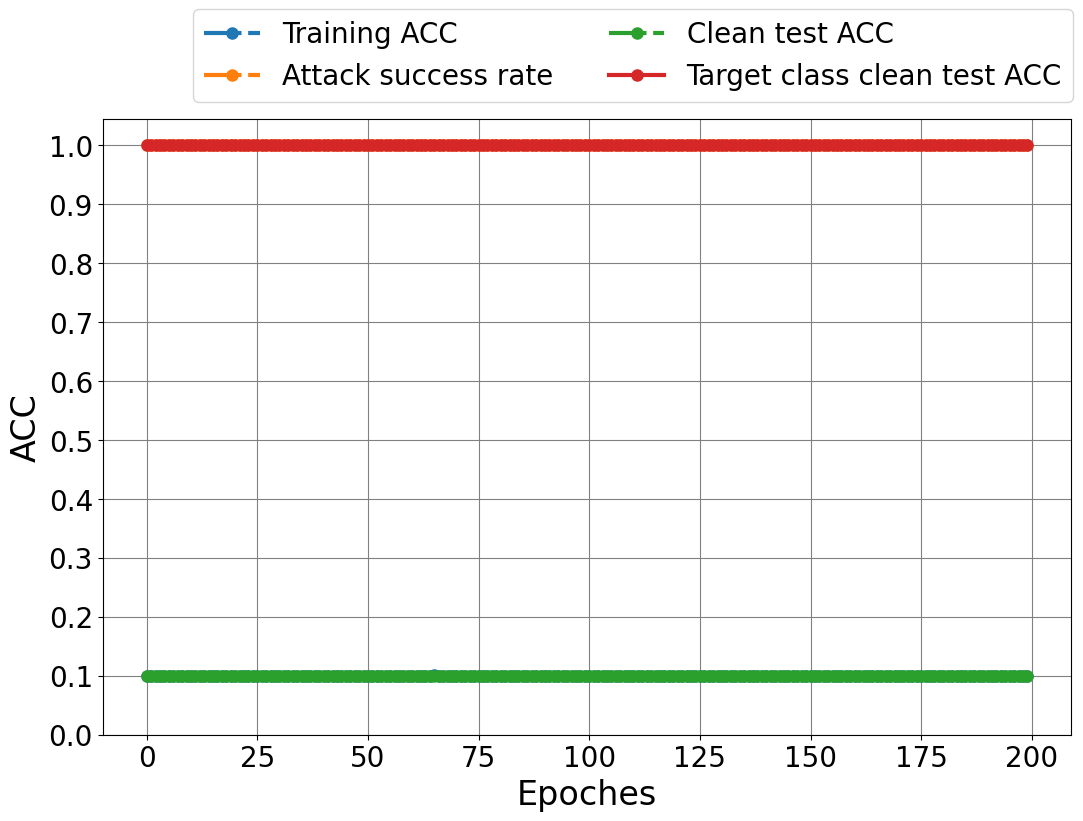

0.10000000000000002
attack 1.0
0
all class clean 0.1
target clean 1.0
Saved training and evaluation metrics to metrics_adaptive_trigger.json


In [ ]:
#cell 27
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx])
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx])
print('target clean',target_ACC[dis_idx])

import json

metrics = {
    "train_ACC": train_ACC,
    "test_ACC": test_ACC,
    "clean_ACC": clean_ACC,
    "target_ACC": target_ACC
}

with open("metrics_adaptive_trigger20.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved training and evaluation metrics to metrics_adaptive_trigger.json")
